In [ ]:
# ===========================
# Investigated the homogeneous binary nucleation of atmospherically-relevant molecules
# =========================== 

# 📊 Generate Plot: 
#     Output radial layers
# ---------------------------
# Table of Contents
# 1️⃣ Radial layers
# ----------------------------

Reading per-atom data...
Data read completed in 0.89 seconds.
Identifying largest clusters at each time point...
Largest clusters identified in 1.18 seconds.
Processing time points...


Processing: 100%|████████████| 201/201 [02:24<00:00,  1.39ns/s]


Plot saved to ./fig/mole_fraction_time_radial_heatmap_filtered_BUT_MET.png


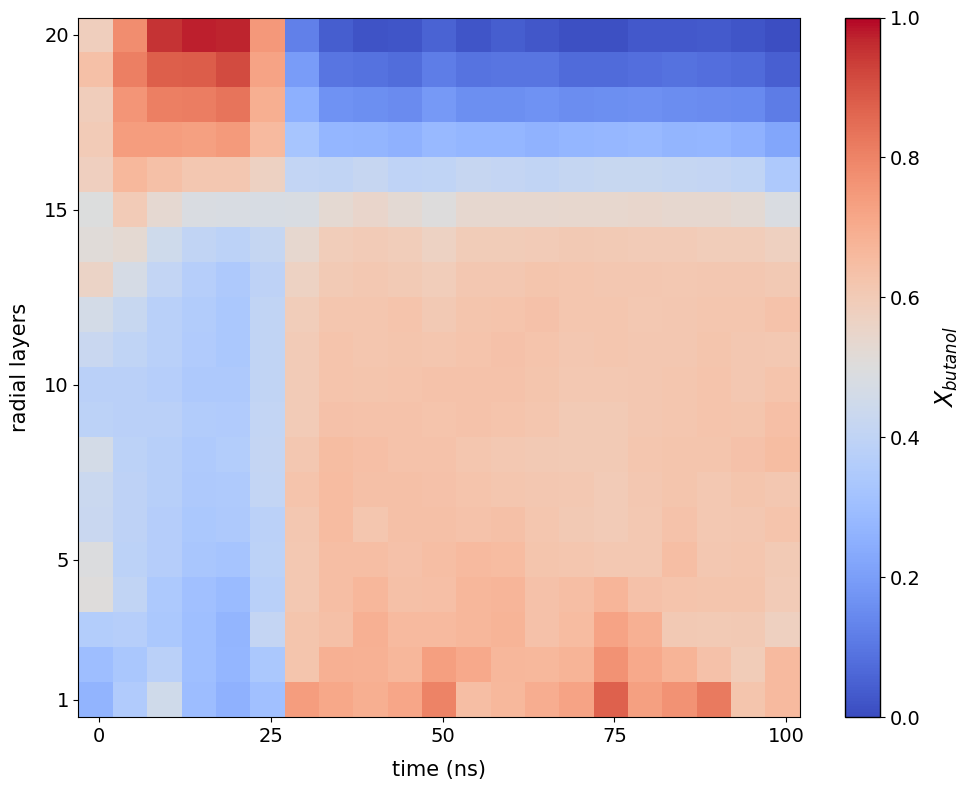

In [1]:
# ===============================
# 1️⃣ Radial layers
# ===============================
# 📆 Date created: October 12, 2024 
# 📆 Date updated: October 13, 2024 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.ndimage import gaussian_filter
import time
from tqdm import tqdm  # Import tqdm for the loading bar
import matplotlib.transforms  # Import transforms for label offset

def plot_mole_fraction_time_radial_heatmap(
    num_layers=5,
    molecule1_name='Molecule1',
    molecule2_name='Molecule2',
    molecule_to_plot='mol1',  # 'mol1' or 'mol2'
    save_path='.',
    filename=None,
    vmin=0.0,
    vmax=1.0,
    x_setting=None,
    y_setting=None,
    cbar_setting=None,
    distance_threshold=20.0,  # Molecules beyond this distance from COM are excluded
    time_average_window=0.5,  # Time averaging window in ns
    gaussian_sigma=1,  # Sigma value for Gaussian filter
    start_time=None,   # Start time in ns
    end_time=None      # End time in ns
):
    """
    Plots a heatmap of mole fraction over time and radial bins, excluding molecules more than
    a specified distance away from the cluster's center of mass. Applies Gaussian interpolation,
    adjusts axis labels, ticks, and allows time averaging.

    Parameters:
    - num_layers: Number of radial layers/bins.
    - molecule1_name: Name of molecule1 for labeling.
    - molecule2_name: Name of molecule2 for labeling.
    - molecule_to_plot: Which molecule's mole fraction to plot ('mol1' or 'mol2').
    - save_path: Directory to save the plot.
    - filename: Name of the output plot file. Molecule names will be appended automatically.
    - vmin, vmax: Minimum and maximum values for the color scale.
    - x_setting: Dictionary for x-axis settings:
        - label: Label for the x-axis.
        - label_size: Font size of the x-axis label.
        - label_pad: Padding for the x-axis label.
        - ticks: Custom ticks for the x-axis.
        - tick_size: Font size of the x-axis ticks.
        - tick_interval: Interval between x-ticks.
        - tick_label_offset: Offset in points to shift x-tick labels and tick marks horizontally.
    - y_setting: Dictionary for y-axis settings (label, label_size, label_pad, ticks, tick_size).
    - cbar_setting: Dictionary for colorbar settings (label, label_size, label_pad, ticks, tick_size).
    - distance_threshold: Molecules beyond this distance from COM are excluded.
    - time_average_window: Time window in ns to average the mole fractions.
    - gaussian_sigma: Sigma value for the Gaussian filter used in interpolation.
    - start_time: Start time in ns for analysis (inclusive).
    - end_time: End time in ns for analysis (inclusive).
    """

    total_start_time = time.time()

    # Set default axis and colorbar settings if None
    if x_setting is None:
        x_setting = {
            'label': 'Time (ns)',
            'label_size': 14,
            'label_pad': 10,
            'ticks': None,
            'tick_size': 12,
            'tick_interval': 10,  # Default xtick_interval
            'tick_label_offset': 0  # Default offset is zero
        }

    if y_setting is None:
        y_setting = {
            'label': 'Radial Layers',
            'label_size': 14,
            'label_pad': 10,
            'ticks': (1, 5, 10, 15, 20),  # Default y-ticks
            'tick_size': 12
        }

    if cbar_setting is None:
        cbar_setting = {
            'label': '$X_{water}$',
            'label_size': 14,
            'label_pad': 10,
            'ticks': None,
            'tick_size': 12
        }

    # Construct filename with molecule names if not provided
    if filename is None:
        filename = 'mole_fraction_time_radial_heatmap'

    # Append molecule names to the filename
    filename = f"{filename}_{molecule1_name}_{molecule2_name}.png"

    # Start reading data
    print("Reading per-atom data...")
    data_start_time = time.time()
    df_atoms = pd.read_parquet('nuc_fort-to-panda_combined.parquet')
    data_end_time = time.time()
    print(f"Data read completed in {data_end_time - data_start_time:.2f} seconds.")

    # Convert frame number to time (assuming each frame is 0.5 ns)
    df_atoms['time_ns'] = df_atoms['frame_number'] * 0.5

    # Filter data based on the specified time range
    if start_time is not None or end_time is not None:
        df_atoms = df_atoms[
            (df_atoms['time_ns'] >= (start_time if start_time is not None else df_atoms['time_ns'].min())) &
            (df_atoms['time_ns'] <= (end_time if end_time is not None else df_atoms['time_ns'].max()))
        ]

    # Identify the largest cluster at each time point
    print("Identifying largest clusters at each time point...")
    cluster_start_time = time.time()
    nucleus_sizes = df_atoms.groupby(['time_ns', 'nucleus_id']).size().reset_index(name='size')
    largest_nuclei = nucleus_sizes.sort_values(['time_ns', 'size'], ascending=[True, False]).drop_duplicates(['time_ns'])
    df_largest_nuclei = pd.merge(df_atoms, largest_nuclei[['time_ns', 'nucleus_id']], on=['time_ns', 'nucleus_id'])
    cluster_end_time = time.time()
    print(f"Largest clusters identified in {cluster_end_time - cluster_start_time:.2f} seconds.")

    # Initialize a list to store mole fraction data
    mole_fraction_records = []

    # Get unique time points
    time_points = df_largest_nuclei['time_ns'].unique()
    time_points.sort()

    # Process each time point with a loading bar
    print("Processing time points...")
    processing_start_time = time.time()

    # Wrap the time_points iterable with tqdm for a progress bar
    for time_ns in tqdm(time_points, desc="Processing", unit="ns"):
        time_point_start = time.time()
        df_time = df_largest_nuclei[df_largest_nuclei['time_ns'] == time_ns]

        # Compute center of mass of the cluster
        x_com = df_time['x_coord'].mean()
        y_com = df_time['y_coord'].mean()
        z_com = df_time['z_coord'].mean()

        # Compute center of mass for each molecule
        df_molecule_com = df_time.groupby('molecule_id').agg({
            'x_coord': 'mean',
            'y_coord': 'mean',
            'z_coord': 'mean',
            'molecule_name': 'first'
        }).reset_index()

        # Compute distances from cluster center of mass to molecule centers of mass
        df_molecule_com['distance_to_com'] = np.sqrt(
            (df_molecule_com['x_coord'] - x_com) ** 2 +
            (df_molecule_com['y_coord'] - y_com) ** 2 +
            (df_molecule_com['z_coord'] - z_com) ** 2
        )

        # Exclude molecules that are more than the distance threshold away
        df_molecule_com_filtered = df_molecule_com[df_molecule_com['distance_to_com'] <= distance_threshold]

        # Merge back to get atom data for filtered molecules
        df_filtered = pd.merge(df_time, df_molecule_com_filtered[['molecule_id']], on='molecule_id')

        # Determine molecule1 and molecule2
        molecule_names = df_filtered['molecule_name'].unique()
        molecules_present = df_filtered['molecule_name'].unique()
        molecule_priority = ['SOL', 'NON', 'BUTA', 'MET']
        molecules_in_priority = [mol for mol in molecule_priority if mol in molecules_present]

        if len(molecules_in_priority) >= 2:
            molecule1 = molecules_in_priority[0]
            molecule2 = molecules_in_priority[1]
        else:
            molecule1 = molecules_in_priority[0] if len(molecules_in_priority) >= 1 else None
            molecule2 = None

        # Select molecule names based on user input
        if molecule1_name == molecule1:
            molecule1 = molecule1_name
        else:
            molecule1 = molecule_names[0]  # Use first molecule found

        if molecule2_name == molecule2:
            molecule2 = molecule2_name
        else:
            molecule2 = molecule_names[1] if len(molecule_names) > 1 else molecule_names[0]

        # Calculate distances of all atoms from the center of mass
        atom_coords = df_filtered[['x_coord', 'y_coord', 'z_coord']].values
        distances = np.linalg.norm(atom_coords - np.array([x_com, y_com, z_com]), axis=1)

        # Calculate the radius of the cluster (maximum distance)
        cluster_radius = distances.max()

        if cluster_radius == 0:
            tqdm.write(f"Cluster radius is zero at time {time_ns} ns. Skipping this time point.")
            continue  # Avoid division by zero

        # Define radial bins as percentages of the radius
        layer_edges = np.linspace(0, 1, num_layers + 1)  # Edges from 0 to 1
        # Convert edges to actual distances
        bin_edges = layer_edges * cluster_radius

        # Initialize counts for each bin and molecule
        bin_counts_mol1 = np.zeros(num_layers)
        bin_counts_mol2 = np.zeros(num_layers)
        bin_total_counts = np.zeros(num_layers)

        # For each molecule in the nucleus
        molecule_atoms = df_filtered.copy()

        # Assign each molecule to a radial bin based on the closest atom to the center
        molecule_atoms['distance'] = np.linalg.norm(
            molecule_atoms[['x_coord', 'y_coord', 'z_coord']].values - np.array([x_com, y_com, z_com]), axis=1
        )

        # Group by molecule_id to get molecules
        molecules_grouped = molecule_atoms.groupby('molecule_id')

        for mol_id, mol_group in molecules_grouped:
            molecule_name = mol_group['molecule_name'].iloc[0]
            min_distance = mol_group['distance'].min()

            # Determine which bin this molecule falls into
            bin_index = np.digitize(min_distance, bin_edges) - 1  # Adjust for zero-based index
            if bin_index >= num_layers or bin_index < 0:
                continue  # Ignore distances outside the range

            # Count molecules in bins
            bin_total_counts[bin_index] += 1
            if molecule_name == molecule1:
                bin_counts_mol1[bin_index] += 1
            elif molecule_name == molecule2:
                bin_counts_mol2[bin_index] += 1

        # Calculate mole fractions
        mole_fraction_mol1 = np.divide(
            bin_counts_mol1, bin_total_counts, out=np.zeros_like(bin_counts_mol1), where=bin_total_counts != 0
        )
        mole_fraction_mol2 = np.divide(
            bin_counts_mol2, bin_total_counts, out=np.zeros_like(bin_counts_mol2), where=bin_total_counts != 0
        )

        # Prepare the result row
        result_row = {
            'time_ns': time_ns,
            'cluster_radius': cluster_radius
        }

        # Add mole fraction values to the result row
        for i in range(num_layers):
            # Mole fractions for each bin
            result_row[f'layer_{i}_mol1'] = mole_fraction_mol1[i]
            result_row[f'layer_{i}_mol2'] = mole_fraction_mol2[i]

        mole_fraction_records.append(result_row)

    # Create DataFrame from records
    df_mole_fractions = pd.DataFrame(mole_fraction_records)

    # Time averaging
    if time_average_window > 0.5:
        df_mole_fractions['time_ns'] = (df_mole_fractions['time_ns'] // time_average_window) * time_average_window
        df_mole_fractions = df_mole_fractions.groupby('time_ns', as_index=False).mean()

    # Melt the DataFrame to long format
    value_vars = [f'layer_{i}_{molecule_to_plot}' for i in range(num_layers)]
    df_melted = df_mole_fractions.melt(
        id_vars=['time_ns'],
        value_vars=value_vars,
        var_name='layer',
        value_name='mole_fraction'
    )
    df_melted['layer_number'] = df_melted['layer'].apply(lambda x: int(x.split('_')[1]))

    # Create pivot table for heatmap
    heatmap_data = df_melted.pivot_table(index='layer_number', columns='time_ns', values='mole_fraction').sort_index(ascending=True)

    # Apply Gaussian interpolation
    heatmap_smoothed = gaussian_filter(np.nan_to_num(heatmap_data.values), sigma=gaussian_sigma)
    heatmap_data_smoothed = pd.DataFrame(heatmap_smoothed, index=heatmap_data.index, columns=heatmap_data.columns)

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        heatmap_data_smoothed,
        cmap='coolwarm',
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': cbar_setting['label']},
        xticklabels=False,
        yticklabels=False
    )

    # Add outline around heatmap
    for _, spine in ax.spines.items():
        spine.set_visible(True)

    # Add outline to colorbar
    colorbar = ax.collections[0].colorbar
    colorbar.outline.set_linewidth(1)  # Adjust linewidth as needed

    # Set x-ticks
    if time_average_window > 0.5:
        step = int(x_setting['tick_interval'] / time_average_window)
    else:
        step = int(x_setting['tick_interval'] / 0.5)
    x_positions = np.arange(len(heatmap_data.columns))
    x_tick_positions = np.arange(0, len(x_positions), step)
    x_tick_labels = ["{:.0f}".format(heatmap_data.columns[i]) for i in x_tick_positions]
    ax.set_xticks(x_tick_positions)
    ax.set_xticklabels(x_tick_labels, fontsize=x_setting['tick_size'])

    # Shift x-tick labels and tick marks if offset is provided
    if 'tick_label_offset' in x_setting and x_setting['tick_label_offset'] != 0:
        dx = x_setting['tick_label_offset']
        # Convert points to display units
        offset = matplotlib.transforms.ScaledTranslation(dx / 72., 0, plt.gcf().dpi_scale_trans)
        for label in ax.get_xticklabels():
            label.set_transform(label.get_transform() + offset)
        for tick in ax.xaxis.get_major_ticks():
            tick.tick1line.set_transform(tick.tick1line.get_transform() + offset)
            tick.tick2line.set_transform(tick.tick2line.get_transform() + offset)
            tick.gridline.set_transform(tick.gridline.get_transform() + offset)

    # Set y-ticks based on y_setting
    if y_setting['ticks'] is not None:
        y_ticks = np.array(y_setting['ticks']) - 1  # Adjust for zero-based index
        y_labels = [str(tick) for tick in y_setting['ticks']]
        ax.set_yticks(y_ticks + 0.5)
        ax.set_yticklabels(y_labels, fontsize=y_setting['tick_size'])
    else:
        ax.set_yticks(np.arange(len(heatmap_data.index)) + 0.5)
        ax.set_yticklabels(heatmap_data.index, fontsize=y_setting['tick_size'])

    plt.gca().invert_yaxis()

    # Set axis labels
    ax.set_xlabel(x_setting['label'], fontsize=x_setting['label_size'], labelpad=x_setting['label_pad'])
    ax.set_ylabel(y_setting['label'], fontsize=y_setting['label_size'], labelpad=y_setting['label_pad'])

    # Customize colorbar
    cbar = ax.collections[0].colorbar
    cbar.set_label(cbar_setting['label'], fontsize=cbar_setting['label_size'], labelpad=cbar_setting['label_pad'])
    cbar.ax.tick_params(labelsize=cbar_setting['tick_size'])
    if cbar_setting['ticks'] is not None:
        cbar.set_ticks(cbar_setting['ticks'])

    plt.tight_layout()

    # Save the plot
    save_full_path = os.path.join(save_path, filename)
    plt.savefig(save_full_path, dpi=300)
    print(f"Plot saved to {save_full_path}")
    plt.show()

# Example usage of the function
plot_mole_fraction_time_radial_heatmap(
    num_layers=20,  # Number of radial bins
    molecule1_name='BUT',  # Replace with actual molecule name
    molecule2_name='MET',  # Replace with actual molecule name
    molecule_to_plot='mol1',  # 'mol1' or 'mol2'
    save_path='./fig/',  # Replace with your desired save path
    filename='mole_fraction_time_radial_heatmap_filtered',
    vmin=0.0,
    vmax=1.0,
    x_setting={
        'label': 'time (ns)',
        'label_size': 15,
        'label_pad': 10,
        'ticks': (0,25,50,75,100),  # Will be set based on tick_interval
        'tick_size': 14,
        'tick_interval': 25,  # Display x-ticks every 25 ns
        'tick_label_offset': 15  # Offset x-tick labels and tick marks by 15 points to the right
    },
    y_setting={
        'label': 'radial layers',
        'label_size': 15,
        'label_pad': 10,
        'ticks': (1, 5, 10, 15, 20),  # Specific y-ticks to display
        'tick_size': 14
    },
    cbar_setting={
        'label': '$X_{butanol}$',
        'label_size': 17,
        'label_pad': 10,
        'ticks': None,  # Default ticks
        'tick_size': 14
    },
    distance_threshold=30.0,  # Molecules beyond 30 Å from COM are excluded
    time_average_window=5.0,  # Average over every 5 ns
    gaussian_sigma=0.5,  # Sigma value for Gaussian interpolation
    start_time=0.0,       # Start time in ns
    end_time=100.0        # End time in ns
)
